In [1]:
%env CUDA_VISIBLE_DEVICES=6
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_AAE_C_results'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [5]:
def to_onehot(data, n, device=None):
    d = torch.tensor(data)
    y = torch.zeros(d.shape[0], n).scatter(1,d[:,None],1)
    return y if not device else y.to(device)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

cuda:0


In [7]:
data, label = next(iter(train_loader))

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, bn=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if bn:
                layers.append(nn.BatchNorm1d(sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [9]:
Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [10]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [11]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [12]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        label = to_onehot(label, 10, device)
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)

        fake_pred = Disc(Enc(data))
        true_pred = Disc(z)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10)
        
        latent = Enc(data)
        reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
        fake_pred = Disc(latent)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [13]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10, device)
            z = torch.randn((batch_size, prior_size)).to(device)
            z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)
            latent = Enc(data)
            reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
            fake_pred = Disc(latent)
            true_pred = Disc(z)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size
        if epoch % 20 == 0:
            fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
            plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
            fixed_reconstruction = Dec(Enc(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
            plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses E: 0.6828, AE: 0.9286, D: 0.7197
Train Epoch: 1 [25000/50000 (50%)]	Losses E: 2.3292, AE: 0.2886, D: 4.5623
Train Epoch: 1 [50000/50000 (100%)]	Losses E: 0.8177, AE: 0.2611, D: 1.6111
Test losses. E: 0.8002, AE: 0.2695, D: 1.5419
Train Epoch: 2 [0/50000 (0%)]	Losses E: 0.8093, AE: 0.2728, D: 1.5638
Train Epoch: 2 [25000/50000 (50%)]	Losses E: 0.5796, AE: 0.2556, D: 0.9927
Train Epoch: 2 [50000/50000 (100%)]	Losses E: 1.3070, AE: 0.2578, D: 0.9274
Test losses. E: 0.7513, AE: 0.2512, D: 0.9354
Train Epoch: 3 [0/50000 (0%)]	Losses E: 1.2595, AE: 0.2518, D: 0.9257
Train Epoch: 3 [25000/50000 (50%)]	Losses E: 0.5944, AE: 0.2530, D: 1.0020
Train Epoch: 3 [50000/50000 (100%)]	Losses E: 0.5407, AE: 0.2282, D: 0.7573
Test losses. E: 0.5340, AE: 0.2315, D: 0.7564
Train Epoch: 4 [0/50000 (0%)]	Losses E: 0.5385, AE: 0.2265, D: 0.7698
Train Epoch: 4 [25000/50000 (50%)]	Losses E: 0.4848, AE: 0.2263, D: 0.8728
Train Epoch: 4 [50000/50000 (100%)]	Losses E: 0.5444, 

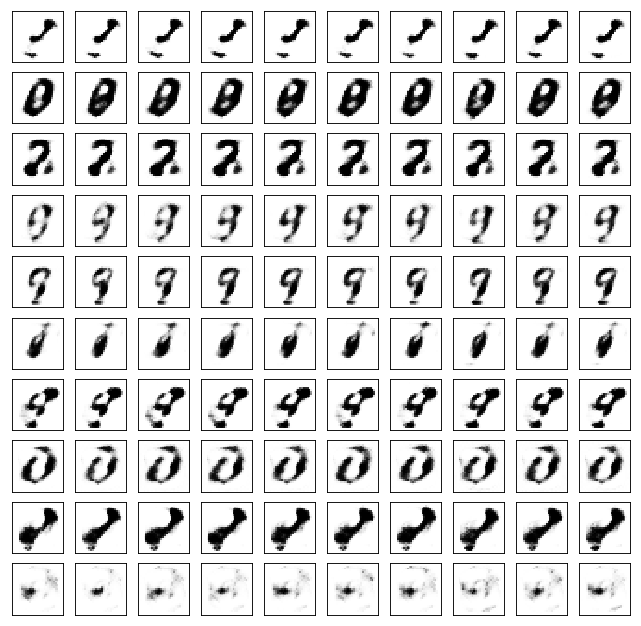

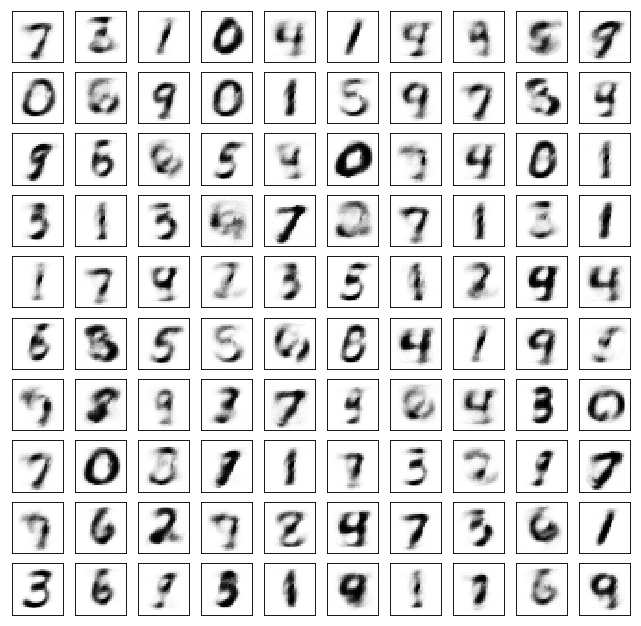

Test losses. E: 0.6724, AE: 0.1459, D: 0.7326
Train Epoch: 21 [0/50000 (0%)]	Losses E: 0.6778, AE: 0.1481, D: 0.7366
Train Epoch: 21 [25000/50000 (50%)]	Losses E: 0.6421, AE: 0.1355, D: 0.7187
Train Epoch: 21 [50000/50000 (100%)]	Losses E: 0.7878, AE: 0.2143, D: 0.7876
Test losses. E: 0.7399, AE: 0.2143, D: 0.8013
Train Epoch: 22 [0/50000 (0%)]	Losses E: 0.7597, AE: 0.2135, D: 0.8039
Train Epoch: 22 [25000/50000 (50%)]	Losses E: 0.6542, AE: 0.1291, D: 0.6953
Train Epoch: 22 [50000/50000 (100%)]	Losses E: 0.9252, AE: 0.1762, D: 0.6249
Test losses. E: 0.8100, AE: 0.1904, D: 0.6460
Train Epoch: 23 [0/50000 (0%)]	Losses E: 0.8793, AE: 0.1865, D: 0.6464
Train Epoch: 23 [25000/50000 (50%)]	Losses E: 0.7189, AE: 0.1396, D: 0.7199
Train Epoch: 23 [50000/50000 (100%)]	Losses E: 0.6395, AE: 0.1484, D: 0.6671
Test losses. E: 0.6243, AE: 0.1533, D: 0.6753
Train Epoch: 24 [0/50000 (0%)]	Losses E: 0.6269, AE: 0.1430, D: 0.6825
Train Epoch: 24 [25000/50000 (50%)]	Losses E: 0.7327, AE: 0.1719, D: 0.82

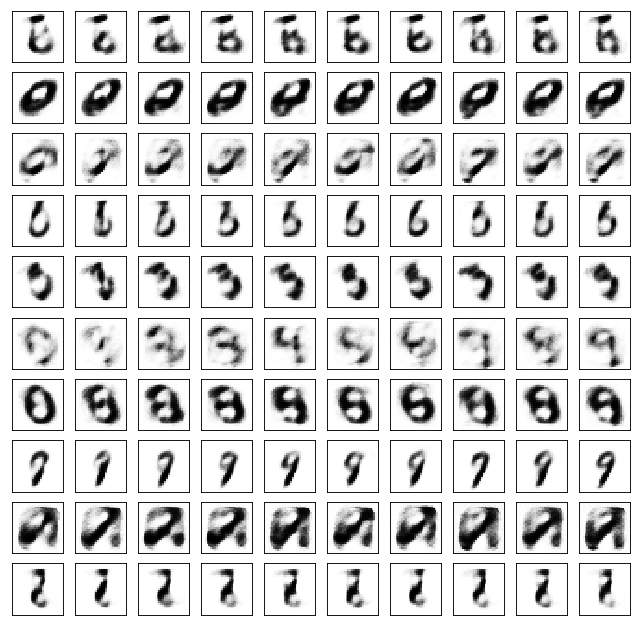

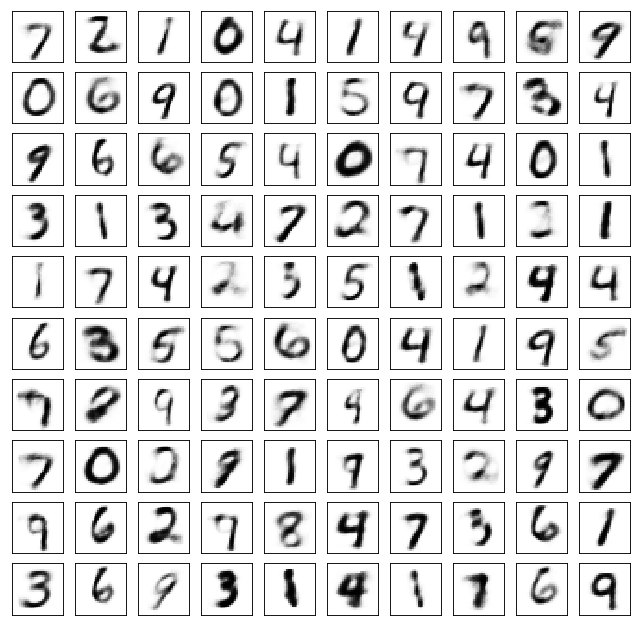

Test losses. E: 0.6627, AE: 0.1000, D: 0.7013
Train Epoch: 41 [0/50000 (0%)]	Losses E: 0.6665, AE: 0.1033, D: 0.7032
Train Epoch: 41 [25000/50000 (50%)]	Losses E: 0.7825, AE: 0.1377, D: 0.6905
Train Epoch: 41 [50000/50000 (100%)]	Losses E: 0.6878, AE: 0.1011, D: 0.6795
Test losses. E: 0.6824, AE: 0.1001, D: 0.6811
Train Epoch: 42 [0/50000 (0%)]	Losses E: 0.6865, AE: 0.1020, D: 0.6836
Train Epoch: 42 [25000/50000 (50%)]	Losses E: 0.6535, AE: 0.0986, D: 0.7065
Train Epoch: 42 [50000/50000 (100%)]	Losses E: 0.7091, AE: 0.1002, D: 0.7010
Test losses. E: 0.7088, AE: 0.0988, D: 0.7003
Train Epoch: 43 [0/50000 (0%)]	Losses E: 0.7064, AE: 0.0965, D: 0.7029
Train Epoch: 43 [25000/50000 (50%)]	Losses E: 0.6322, AE: 0.1005, D: 0.7252
Train Epoch: 43 [50000/50000 (100%)]	Losses E: 0.7715, AE: 0.1168, D: 0.7001
Test losses. E: 0.7603, AE: 0.1160, D: 0.7013
Train Epoch: 44 [0/50000 (0%)]	Losses E: 0.7653, AE: 0.1157, D: 0.7020
Train Epoch: 44 [25000/50000 (50%)]	Losses E: 0.6147, AE: 0.0975, D: 0.70

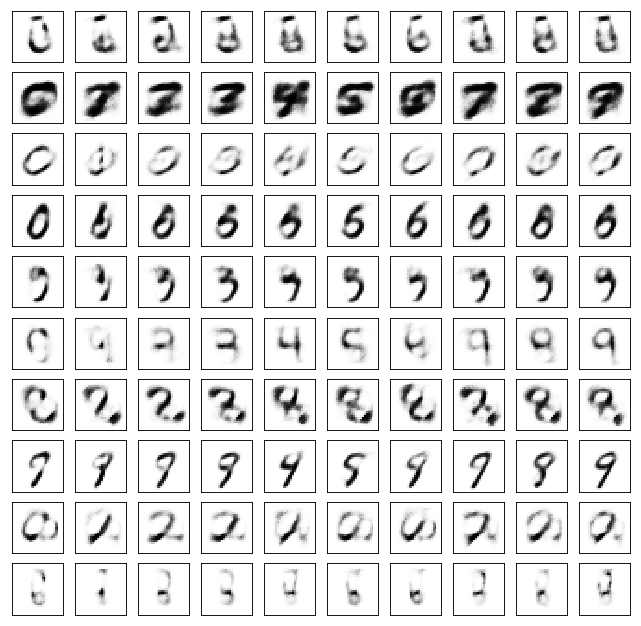

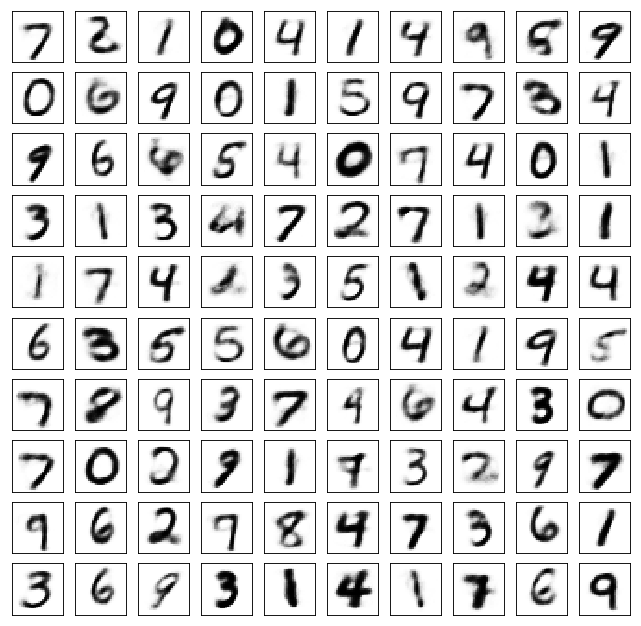

Test losses. E: 0.7529, AE: 0.0904, D: 0.6898
Train Epoch: 61 [0/50000 (0%)]	Losses E: 0.7772, AE: 0.0877, D: 0.6897
Train Epoch: 61 [25000/50000 (50%)]	Losses E: 0.6612, AE: 0.0815, D: 0.7023
Train Epoch: 61 [50000/50000 (100%)]	Losses E: 0.7022, AE: 0.0820, D: 0.7082
Test losses. E: 0.7013, AE: 0.0865, D: 0.7070
Train Epoch: 62 [0/50000 (0%)]	Losses E: 0.6998, AE: 0.0870, D: 0.7075
Train Epoch: 62 [25000/50000 (50%)]	Losses E: 0.7319, AE: 0.0939, D: 0.7187
Train Epoch: 62 [50000/50000 (100%)]	Losses E: 0.6957, AE: 0.0784, D: 0.6957
Test losses. E: 0.6968, AE: 0.0798, D: 0.6940
Train Epoch: 63 [0/50000 (0%)]	Losses E: 0.6965, AE: 0.0811, D: 0.6940
Train Epoch: 63 [25000/50000 (50%)]	Losses E: 0.6978, AE: 0.0816, D: 0.7021
Train Epoch: 63 [50000/50000 (100%)]	Losses E: 0.7664, AE: 0.0920, D: 0.6962
Test losses. E: 0.7556, AE: 0.0931, D: 0.6973
Train Epoch: 64 [0/50000 (0%)]	Losses E: 0.7682, AE: 0.0927, D: 0.6958
Train Epoch: 64 [25000/50000 (50%)]	Losses E: 0.6482, AE: 0.0866, D: 0.70

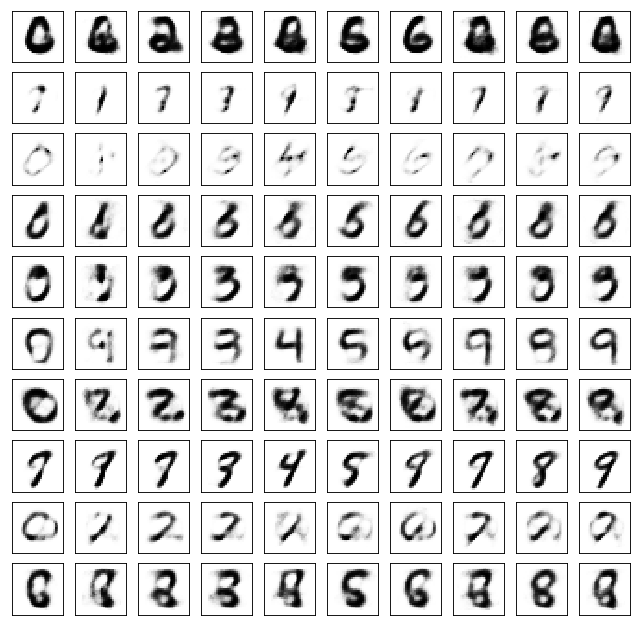

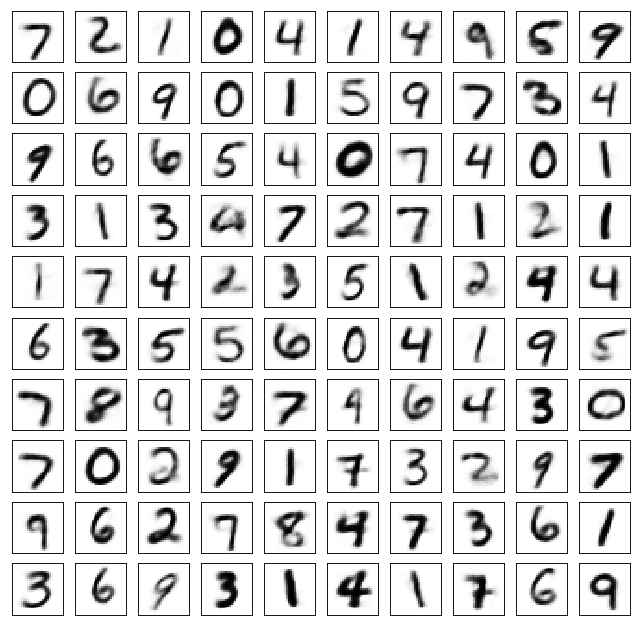

Test losses. E: 0.7208, AE: 0.0783, D: 0.7046
Train Epoch: 81 [0/50000 (0%)]	Losses E: 0.7243, AE: 0.0789, D: 0.7030
Train Epoch: 81 [25000/50000 (50%)]	Losses E: 0.7420, AE: 0.0767, D: 0.7051
Train Epoch: 81 [50000/50000 (100%)]	Losses E: 0.7603, AE: 0.0828, D: 0.6999
Test losses. E: 0.7594, AE: 0.0818, D: 0.6977
Train Epoch: 82 [0/50000 (0%)]	Losses E: 0.7612, AE: 0.0818, D: 0.6996
Train Epoch: 82 [25000/50000 (50%)]	Losses E: 0.6917, AE: 0.0830, D: 0.6935
Train Epoch: 82 [50000/50000 (100%)]	Losses E: 0.6665, AE: 0.0744, D: 0.6985
Test losses. E: 0.6638, AE: 0.0723, D: 0.6996
Train Epoch: 83 [0/50000 (0%)]	Losses E: 0.6629, AE: 0.0686, D: 0.7010
Train Epoch: 83 [25000/50000 (50%)]	Losses E: 0.7082, AE: 0.0829, D: 0.7031
Train Epoch: 83 [50000/50000 (100%)]	Losses E: 0.6837, AE: 0.0700, D: 0.6991
Test losses. E: 0.6842, AE: 0.0731, D: 0.6974
Train Epoch: 84 [0/50000 (0%)]	Losses E: 0.6833, AE: 0.0761, D: 0.6989
Train Epoch: 84 [25000/50000 (50%)]	Losses E: 0.7288, AE: 0.0694, D: 0.69

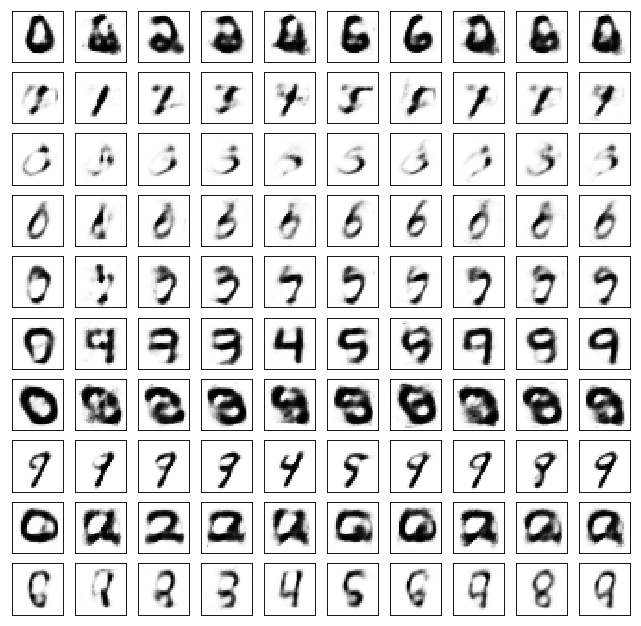

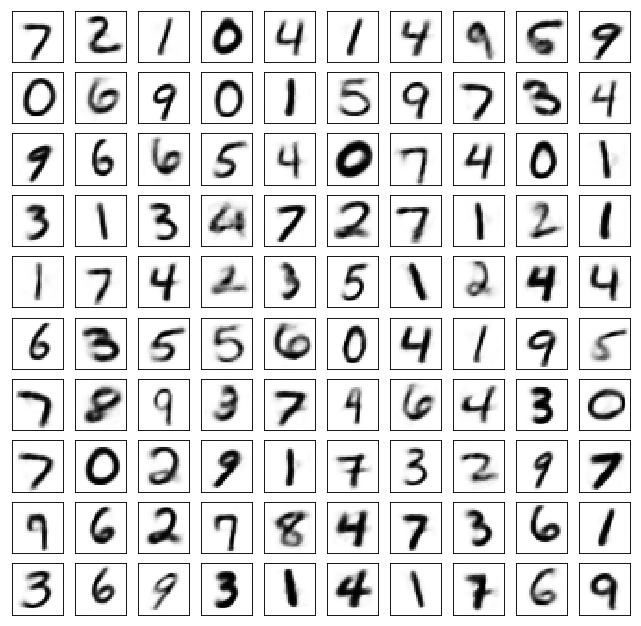

Test losses. E: 0.7370, AE: 0.0697, D: 0.6972


In [14]:
for epoch in range(1, 101):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)

In [15]:
torch.save(Enc.state_dict(),'aae_c_enc.100e.pt')
torch.save(Dec.state_dict(),'aae_c_dec.100e.pt')
torch.save(Disc.state_dict(),'aae_c_disc.100e.pt')

## Train classifiers on original images and latent representation

In [16]:
class Classifier(nn.Module):
    def __init__(self, sizes, flatten = False):
        super().__init__()
        self.fc = FullyConnected(sizes, 
                                 activation_fn=nn.ReLU(), 
                                 last_fn=nn.LogSoftmax(dim=1),
                                 dropout = 0.2,
                                 bn=True, 
                                 flatten=flatten)
        self.optim = optim.Adam(self.fc.parameters(), lr=1e-4)
    
    def forward(self, x):
        x = self.fc(x)
        return x

In [17]:
def train_clf(epoch, clf, loader):
    train_loss = 0.0
    train_accuracy = 0.0
    total_samples = 0.0
    clf.train()
    for batch, (data, label) in enumerate(loader):
        clf.optim.zero_grad()
        data = torch.tensor(data).cuda()
        label = torch.tensor(label).cuda()
        
        output = clf(data)
        loss = F.nll_loss(output, label)
        loss.backward()
        clf.optim.step()
        
        train_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        train_accuracy += (pred == label).sum().item()
        total_samples += data.shape[0]

    train_loss /= len(train_data)
    print("Epoch {:2d}: loss {:.4f}, accuracy {:.2f}%".format(epoch, train_loss, 100 * train_accuracy/ total_samples))

In [18]:
def test_clf(epoch, clf, loader):
    test_loss = 0.0
    test_accuracy = 0.0
    total_samples = 0.0
    clf.eval()
    for batch, (data, label) in enumerate(loader):
        data = torch.tensor(data).cuda()
        label = torch.tensor(label).cuda()
        
        output = clf(data)
        loss = F.nll_loss(output, label)
                
        test_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        test_accuracy += (pred == label).sum().item()
        total_samples += data.shape[0]

    test_loss /= len(test_data)
    print("Test  {:2d}: loss {:.4f}, accuracy {:.2f}%".format(epoch, test_loss, 100 * test_accuracy / total_samples))

### Create train/test dataset from latent representation

In [19]:
Enc.eval()
train_data = []
test_data = []
for data, label in train_loader:
    data = data.cuda()
    train_data.append((Enc(data).data.cpu().numpy(), label.data.numpy()))
    
for data, label in test_loader:
    data = data.cuda()
    test_data.append((Enc(data).data.cpu().numpy(), label.data.numpy()))    

### Train classifier on original images

In [20]:
image_clf = Classifier([28*28, 2048, 1024, 512, 10], flatten=True).cuda()
image_clf

Classifier(
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=784, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=1024, bias=True)
      (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.2)
      (7): ReLU()
      (8): Linear(in_features=1024, out_features=512, bias=True)
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Dropout(p=0.2)
      (11): ReLU()
      (12): Linear(in_features=512, out_features=10, bias=True)
      (13): LogSoftmax()
    )
  )
)

In [21]:
for epoch in range(1,11):
    train_clf(epoch, image_clf, train_loader)
    test_clf(epoch, image_clf, test_loader)

Epoch  1: loss 0.6270, accuracy 88.02%
Test   1: loss 0.2228, accuracy 95.25%
Epoch  2: loss 0.1970, accuracy 95.80%
Test   2: loss 0.1187, accuracy 97.10%
Epoch  3: loss 0.1169, accuracy 97.32%
Test   3: loss 0.0890, accuracy 97.57%
Epoch  4: loss 0.0788, accuracy 98.19%
Test   4: loss 0.0708, accuracy 98.05%
Epoch  5: loss 0.0568, accuracy 98.68%
Test   5: loss 0.0688, accuracy 97.91%
Epoch  6: loss 0.0422, accuracy 99.02%
Test   6: loss 0.0589, accuracy 98.23%
Epoch  7: loss 0.0320, accuracy 99.28%
Test   7: loss 0.0589, accuracy 98.10%
Epoch  8: loss 0.0248, accuracy 99.47%
Test   8: loss 0.0565, accuracy 98.22%
Epoch  9: loss 0.0203, accuracy 99.54%
Test   9: loss 0.0582, accuracy 98.15%
Epoch 10: loss 0.0170, accuracy 99.63%
Test  10: loss 0.0594, accuracy 98.18%


### Train classifier on latent representation

In [22]:
latent_clf = Classifier([prior_size, 2048, 1024, 512, 10]).cuda()
latent_clf

Classifier(
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=10, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=1024, bias=True)
      (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.2)
      (7): ReLU()
      (8): Linear(in_features=1024, out_features=512, bias=True)
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Dropout(p=0.2)
      (11): ReLU()
      (12): Linear(in_features=512, out_features=10, bias=True)
      (13): LogSoftmax()
    )
  )
)

In [23]:
for epoch in range(1,11):
    latent_clf.train()
    train_clf(epoch, latent_clf, train_data)
    latent_clf.eval()
    test_clf(epoch, latent_clf, test_data)

Epoch  1: loss 0.9365, accuracy 74.83%
Test   1: loss 0.5225, accuracy 85.60%
Epoch  2: loss 0.5179, accuracy 84.75%
Test   2: loss 0.3874, accuracy 88.04%
Epoch  3: loss 0.4255, accuracy 86.65%
Test   3: loss 0.3401, accuracy 89.06%
Epoch  4: loss 0.3829, accuracy 87.66%
Test   4: loss 0.3090, accuracy 89.91%
Epoch  5: loss 0.3545, accuracy 88.39%
Test   5: loss 0.2921, accuracy 90.57%
Epoch  6: loss 0.3342, accuracy 88.97%
Test   6: loss 0.2815, accuracy 90.70%
Epoch  7: loss 0.3194, accuracy 89.39%
Test   7: loss 0.2712, accuracy 91.08%
Epoch  8: loss 0.3094, accuracy 89.56%
Test   8: loss 0.2677, accuracy 91.07%
Epoch  9: loss 0.2969, accuracy 89.94%
Test   9: loss 0.2609, accuracy 91.45%
Epoch 10: loss 0.2905, accuracy 90.14%
Test  10: loss 0.2545, accuracy 91.46%
